# Table of Contents

1.  [Introduction](#org03da1c8)
2.  [Codes](#org821ef87)
    1.  [Importing libraries](#org00f7d8f)
    2.  [Simulation Parameters](#org18bc7e7)
    3.  [Calibration Parameters](#orgc4d3728)
    4.  [Utility Functions](#orgea9f128)
    5.  [Calibration Data](#org36af888)
    6.  [Calibration Dependent Simulation Parameters](#org8a09b9e)
    7.  [Stress Period Functions](#org992eff2)
    8.  [Flopy Model](#orge4d7576)
    9.  [Simulation Post Processing](#orgbd136c6)
    10. [Plots](#org5a8dad9)
3.  [Summary of Calibration Trials](#org57ff250)
4.  [Export to vtk format](#org7cabdb7)


<a id="org03da1c8"></a>

# Introduction

Planning to install a new 250 GPM well at their main facility, a small manufacturer hires you to determine whether their proposed well (see above) will cause any problems with the stream and an existing well and whether the new well or the existing well would likely become contaminated by a nearby TCE plume as a result of the operation of the new well. The new well will be operated continuously.

Geologic data indicate a water table aquifer with bottom elevation of –100ft in this area. The aquifer abruptly pinches out at west and southern boundaries. Ground surface elevation in the area is approximately 3m. A 1st-order stream (average depth=1m) flowing through the area empties into the deep lake (water surface elevation 0.00m) in the NE corner of the map. The stream is predominantly fed by groundwater, meaning the streamflow is essentially baseflow.

Although there has been no study of actual recharge rates to this aquifer, long term average recharge from precipitation in this part of the state varies between 10 and 18 inches/yr depending on the location of the aquifer.

Only one well in the vicinity currently pumps (200 GPM) from this aquifer. This well has been operating continuously for the past 15 years.

This past August, in anticipation of the need to understand this aquifer better, 45 piezometers were installed to determine the water table variation throughout the area. In addition, stream water levels and stream discharges were measured. Average stream discharge measured at a cross section approaching the lake was 1486.65 m³/d (272.73 GPM). The streambed leakance (hydraulic conductivity per unit thickness of the streambed) is unknown and must be calibrated. Annual average water table elevations and stream water levels are provided.


<a id="org821ef87"></a>

# Codes

<a id="org00f7d8f"></a>

## Importing libraries

Same as in other exercises few python libraries are loaded, this one here has many libraries as we're using more and more advanced features.

`matplotlib.gridspec` is for plotting multiple plots in a grid. `pandas` is for loading river head values from csv file, and `scipy.interpolate` is being used to interpolate the head values from river nodes into each cell.

In [1]:
import math
import flopy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.interpolate import interp2d

from shapely import geometry

This function here makes a `shapely.geometry` shape from csv file. We'll later use this to load lake and river from their co-ordinates.

In [2]:
def csv_2_shape(csvfile, shape=geometry.Polygon):
    df = pd.read_csv(csvfile)
    return shape([
        (row.x, row.y) for i, row in df.iterrows()])

<a id="org18bc7e7"></a>

## Simulation Parameters

Simulation grid specifications.

In [3]:
X0 = 0
XN = 3000
NC = 100
ΔX = XN/NC

Y0 = 0
YN = 2230
NR = 75
ΔY = YN/NR

Top = 3                         # m
Height = 100*0.3048
Bottom = Top-Height


There is only one geolayer for this simulation.



In [4]:
geolyr_thickness = [Height]
geolyr_subdivisions = [50]


This parameters is used to determine whether to include second well in the simulation or not. For now it’s false for calibration purposes.

In [5]:
SECOND_WELL_ON = False

Let’s define the grid points for later use.

In [6]:
xy_grid_points = np.mgrid[X0:XN:ΔX, YN:Y0:-ΔY].reshape(2, -1).T
x_grids = np.linspace(X0, XN+1, NC)

Domain and lake geometry definitions along with lake parameters.

In [7]:
domain = geometry.box(X0, Y0, XN, YN)
lake = csv_2_shape('./data/4_lake.csv', geometry.Polygon)
lake_top = 0
lake_height = Height
lake_bottom = lake_top - lake_height
lake_bed_thickness = 1                               # m
lake_conductance = 5 #* ΔX * ΔY / lake_bed_thickness  # leakance to conductance how?

Here we'll define river geometry from the csv, and we'll also use the csv data to define a function `get_river_head` which we can pass `(x, y)` co-ordinate to and get the head value interpolated from river nodes.

In [8]:
river_df = pd.read_csv('./data/4_river.csv')
river = geometry.LineString([
        (row.x, row.y) for i, row in river_df.iterrows()])
get_river_head = interp2d(river_df.x,
                           river_df.y,
                           river_df.h,
                           kind='linear')

Now other parameters for the river.

In [9]:
river_top = 0
river_height = Height
river_bottom = river_top - river_height
river_width = 1
riverbed_thickness = 1

Well definitions.

In [10]:
well1 = geometry.Point((2373.8920225624497, 1438.255033557047))
well1_top = 0
well1_bottom = Bottom
well1_rate = -200 * 5.451  # GPM → m³/day

well2 = geometry.Point((1871.071716357776, 1030.7494407158838))
well2_top = 0
well2_bottom = Bottom
well2_rate = -250 * 5.451  # GPM → m³/day

<a id="orgc4d3728"></a>

## Calibration Parameters

Here the parameters defined can be changed to get different results and these parameters are unknown. The current values are obtained after running batch process with a ton of parameters and selecting the best one.

In [11]:
Kh = 4.48
riv_cond = .01
# between 10-18 inch/year
Rch = 18                        # inch/year
rech = Rch * 0.0254 / 365                  # m/day

<a id="orgea9f128"></a>

## Utility Functions

This function here can be used to find the conductance of river cell, it'll use the intersection length of river with the cell to calculate the equivalent conductance. For now, river width and riverbed thickness are put in arbitrarily, but since we're calibrating it anyway, it should be fine.

In [12]:
def get_riv_conductance(intersect_length):
    "Give conductance based on river intersection on grid."
    return (riv_cond *
            intersect_length * river_width / (ΔX*ΔY)  # factor of area covered
            / riverbed_thickness)

Now the same function to get the layers as in the previous models.

In [13]:
def get_layers(top=Top, bottom=Bottom):
    all_layers = [(i, b) for i, b in enumerate(bot) if b < top]
    b = top
    for i, b in all_layers:
        if b > bottom:
            yield i, top, b
        else:
            break
        top = b
    if b <= bottom:
        yield i, top, bottom

Similarly, a function to get the grid points. This one is a little more complex than the ones in the previous ones as we needed to calculate the conductance for each grid cell so it now returns the intersection length for linestring and intersection area for polygons.

You can provide a shape and it'll give you the grid points, shape can only be `geometry.Point`, `geometry.Polygon` or `geometry.LineString`.

In [14]:
def get_grid_points(shape, /, xy_grid_points, layers=None):
    if not layers:
        layers = [0]
    else:
        layers = list(layers)

    grid_pts = enumerate(map(geometry.Point, xy_grid_points))
    grid_boxes = enumerate(map(lambda x: geometry.box(
            x[0]-ΔX/2, x[1]-ΔY/2, x[0]+ΔX/2, x[1]+ΔY/2),
                            xy_grid_points))

    if isinstance(shape, geometry.Polygon):
        points = filter(lambda gp: shape.contains(gp[1]), grid_boxes)
        points = map(lambda gp: (gp[0], shape.intersection(gp[1]).area), points)
    elif isinstance(shape, geometry.Point):
        nearest = min(grid_pts, key=lambda gp: shape.distance(gp[1]))
        points = [(nearest[0], nearest[1].area)]
    elif isinstance(shape, geometry.LineString):
        points = filter(lambda gp: shape.intersects(gp[1]), grid_boxes)
        points = map(lambda gp: (gp[0], shape.intersection(gp[1]).length), points)

    for i, insec in points:
        col = i // (NR)
        row = i % (NR)
        for j in layers:
            yield (j, row, col), xy_grid_points[i], insec

<a id="org36af888"></a>

## Calibration Data

We'll also load the calibration data for the observation wells, we'll get the grid points for all those wells so we can use that to extract the model heads at those wells later.

In [15]:
calib_wells = pd.read_csv("./data/4_wells.csv")
calib_wells_grid_pts = list(calib_wells.apply(
                lambda row: next(get_grid_points(
                    geometry.Point(row.x, row.y),
                    xy_grid_points=xy_grid_points))[0], axis=1))

Here we can see how our calibration data is:

In [16]:
calib_wells.head()

,well,x,y,h,weight
0,1,1138.014528,1776.654749,12.10,1
1,2,571.428571,766.212291,14.95,1
2,3,479.418886,1896.375419,14.79,1
3,4,1452.784504,680.013408,12.14,1
4,5,479.418886,713.535196,15.13,1


And the grid points for the well that are obtained. The layer is not useful as we’ll look at the watertable data which is 2 dimensional.

In [17]:
calib_wells_grid_pts[:5]

[(0, 15, 38), (0, 49, 19), (0, 11, 16), (0, 52, 48), (0, 51, 16)]

<a id="org8a09b9e"></a>

## Calibration Dependent Simulation Parameters

Using the geolayer information we'll make the computational layers and use same hydraulic conductivity for all layers. So first we'll define a lookup table and geolayer characteristics.

In [18]:
NLay = sum(geolyr_subdivisions)
lookup_table = np.concatenate(
    list(np.ones(s, dtype=int)*i for i, s in
         enumerate(geolyr_subdivisions)))

lyr_k_hz = [Kh]
lyr_k_vt = [Kh]

Here we’ll calculate the bottom elevation for all the layers that we’ll need for descritization package.

In [19]:
thickness = np.zeros(NLay)
k_hz = [0 for i in range(NLay)]
k_vt = [0 for i in range(NLay)]
bot = np.ones(NLay)

Now we’ll populate the values for the arrays we defined above.

In [20]:
for lay in range(NLay):
    geo_lay = lookup_table[lay]
    thickness[lay] = geolyr_thickness[geo_lay]/geolyr_subdivisions[geo_lay]
    k_hz[lay] = lyr_k_hz[geo_lay]
    k_vt[lay] = lyr_k_vt[geo_lay]
    bot[lay] = Top-sum(thickness)

<a id="org992eff2"></a>

## Stress Period Functions

The function gives the river stress period data for river package. It'll use the grid points that intersect with the river, and then calculate conductivity based on that intersection to finally return it. Head and conductance as well as grid points are calculated using the functions defined earlier.

In [21]:
def get_riv_stress_period():
    "gives the stress_period_data on the grid_points for river grids."
    for grid_pt, pt, length in get_grid_points(river, xy_grid_points=xy_grid_points):
        # cellid, stage, cond, rbot, aux, boundname
        stage = get_river_head(pt[0], pt[1])[0]
        rbot = stage-1
        lyrs = get_layers(stage, rbot)
        for l, t, b in lyrs:
            yield ((l, grid_pt[1], grid_pt[2]), stage,
                   get_riv_conductance(length), b)

Similarly for constant head boundaries, we’ll also add the lake heads.



In [22]:
def get_chd_stress_period():
    "gives the stress_period_data on the grid_points for constant head points."
    layers_tuple = list(get_layers(top=lake_top, bottom=lake_bottom))
    for grid_pt, _, _ in get_grid_points(lake, xy_grid_points=xy_grid_points):
        for lay, thk, bottom in layers_tuple:
            # cellid, head
            yield ((lay, grid_pt[1], grid_pt[2]), lake_top)

    for grid_pt, pt, _ in get_grid_points(river, xy_grid_points=xy_grid_points):
        # cellid, head
        stage = get_river_head(pt[0], pt[1])[0]
        rbot = stage-1
        lyrs = get_layers(stage, rbot)
        for l, t, b in lyrs:
            yield ((l, grid_pt[1], grid_pt[2]), stage)

Now the stress period data for wells. Second well stress period data is only added if the variable `SECOND_WELL_ON` is `True`.

In [23]:
def get_well_stress_period():
    well1_layers = [l[0] for l in get_layers(well1_top, well1_bottom)]
    well1_pts = get_grid_points(well1, xy_grid_points=xy_grid_points,
                               layers=well1_layers)
    rate1 = well1_rate/len(well1_layers)
    spd = [(wpt, rate1) for wpt, _, _ in well1_pts]
    if SECOND_WELL_ON:
        well2_layers = [l[0] for l in get_layers(well2_top, well2_bottom)]
        well2_pts = get_grid_points(well2, xy_grid_points=xy_grid_points,
                                   layers=well2_layers)
        rate2 = well2_rate/len(well2_layers)
        spd += [(wpt, rate2) for wpt, _, _ in well2_pts]
    return {0: spd}

To see the stress period heads are correct we can plot it.

In [24]:
sp = list(get_chd_stress_period())

x = [l[0][2] for l in sp]+[0]
y = [l[0][1] for l in sp]+[0]
c = [l[1] for l in sp] + [None]

/usr/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning: NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.convert(mode='P', dither=Image.NONE,
/usr/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning: ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.
  palette=Image.ADAPTIVE, colors=num_colors)


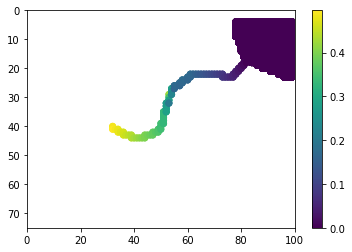

In [25]:
plt.scatter(x, y, c=c)
plt.xlim(left=0, right=NC)
plt.ylim(bottom=NR, top=0)
plt.colorbar()
filename="./images/4_calib_input.pdf"
plt.savefig(filename)
plt.show()

<a id="orge4d7576"></a>

## Flopy Model

Let's define the paths and the executable for simulation.

In [26]:
ws = './models/4_calibration'
name = '4_calibration'

sim = flopy.mf6.MFSimulation(sim_name=name,
                             sim_ws=ws,
                             exe_name='modflow-mf6')

The time descritization will use default parameters as we want steady state. We’ll use days as time unit.

In [27]:
tdis = flopy.mf6.ModflowTdis(sim,
                             time_units='days')
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

Now using the previously defined parameters let’s define the descritization package to define our model grid.



In [28]:
dis = flopy.mf6.ModflowGwfdis(gwf,
                              length_units='METERS',
                              nlay=NLay,
                              nrow=NR,
                              ncol=NC,
                              delc=ΔX,
                              delr=ΔY,
                              top=Top,
                              botm=bot)

We’ll use the top elevation as the initial head for all the cells except for the cells that belongs to the constant head boundaries.

In [29]:
initial_head = np.ones((NLay, NR, NC)) * Top
for gp, head in get_chd_stress_period():
    initial_head[gp] = head

ic = flopy.mf6.ModflowGwfic(gwf, strt=initial_head)

For recharge we’ll use the parameter defined above.

In [30]:
recharge = flopy.mf6.ModflowGwfrcha(gwf, recharge=rech)

We’ll modify the cells that are on the river extent to have the same vertical conductance as that of the river bed. It’ll simulate the river bed leakance for us.

In [31]:
k_vt_new = np.ones(shape=(NLay, NR, NC))*Kh

for gp, _, cond, _ in get_riv_stress_period():
    k_vt_new[gp] = cond

We’ll use the modified vertical conductance for the k33 variable and constant value for horizontal one.

In [32]:
npf = flopy.mf6.ModflowGwfnpf(gwf,
                              icelltype=1,
                              k=k_hz,
                              k33=k_vt_new,
                              save_specific_discharge=True)

Now we’ll define the chd package.



In [33]:
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=list(get_chd_stress_period()))

The riv package.

In [34]:
rivers = flopy.mf6.ModflowGwfriv(
    gwf,
    stress_period_data=list(get_riv_stress_period()))

Now the well stress period.

In [35]:
wells = flopy.mf6.ModflowGwfwel(
    gwf,
    stress_period_data=get_well_stress_period())

Files to save the output data.

In [36]:
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'),
                                        ('BUDGET', 'ALL')])

Now finally we can save the files and run modflow simulation.

In [37]:
sim.write_simulation()
result,_ = sim.run_simulation()
result

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model 4_calibration...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package rcha_0...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 16320 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 220 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 46 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: /usr/local/bin/modflow-mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

  MODFLOW 6 compiled 

True

<a id="orgbd136c6"></a>

## Simulation Post Processing

We can extract the simulation output from the simulation.

In [38]:
head_arr = gwf.output.head().get_data()
bud = gwf.output.budget()

And use the postprocessing tools to get the watertable as well as the specific discharges.

In [39]:
watertable = flopy.utils.postprocessing.get_water_table(head_arr, -1e30)
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

Now we can get the head value from the watertable for all the well grid points.

In [40]:
model_heads = map(lambda x: watertable[(x[1], x[2])], calib_wells_grid_pts)

By doing some calculations we can calculate the errors for individual wells. Let’s also calculate the size and color for the wells based on the absolute error and is it below or above the predicted value.

In [41]:
calib_wells.loc[:, 'model_h'] = pd.Series(model_heads)
calib_wells.loc[:, 'err'] = calib_wells.model_h - calib_wells.h
calib_wells.loc[:, 'sq_err'] = calib_wells.err * calib_wells.err
calib_wells.loc[:, 'pt_size'] = calib_wells.err.map(lambda x: abs(x))
calib_wells.loc[:, 'pt_color'] = calib_wells.err.map(lambda x: 'red' if x>0 else 'blue')

The RMSE and NSE values can be calculated from the individual error values.

In [42]:
rmse = math.sqrt(calib_wells.sq_err.sum())
nse = 1 - calib_wells.sq_err.sum()/(calib_wells.h - calib_wells.h.mean()).map(lambda x: x**2).sum()

print(f'Rch={Rch} inch/year; K={Kh} m/day; RK={riv_cond} ; RMSE={rmse}; NSE={nse}')

Rch=18 inch/year; K=4.48 m/day; RK=0.01 ; RMSE=10.076239940964998; NSE=0.8301897496017947


Rch=18 inch/year; K=4.48 m/day; RK=0.01 ; RMSE=10.076239940964998; NSE=0.8301897496017947

<a id="org5a8dad9"></a>

## Plots

/tmp/ipykernel_46230/3771384213.py:29: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


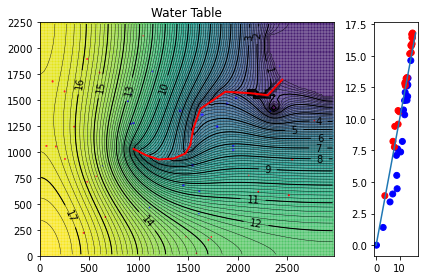

In [43]:
gs = gs = gridspec.GridSpec(1, 5)
fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(gs[0, :4])

ax1.set_title('Water Table')
pmv = flopy.plot.PlotMapView(gwf, ax=ax1)
pmv.plot_array(watertable)
pmv.plot_grid(colors='white', linewidths=0.3)
contours = pmv.contour_array(watertable,
                             levels=np.arange(0, 100, 1),
                             linewidths=1.,
                             colors='black')
ax1.clabel(contours, fmt="%.0f")
pmv.contour_array(watertable,
                  levels=np.arange(0, 100, .2),
                  linewidths=.4,
                  colors='black')
ax1.plot(river_df.x, river_df.y, linewidth=2, color='red')

ax1.scatter(calib_wells.x, calib_wells.y,
           s=calib_wells.pt_size,
           c=calib_wells.pt_color)


ax2 = fig.add_subplot(gs[0, 4])
ax2.scatter(calib_wells.h, calib_wells.model_h, c=calib_wells.pt_color)
max_h = max(calib_wells.h.max(), calib_wells.model_h.max())
plt.plot([0, max_h], [0, max_h])
fig.tight_layout()
plt.savefig("./images/4_calibration.png")
plt.show()

Here in the plot we can see the points above and below the model lines with red and blue color respectively. Seeing the distribution of errors we can adjust the values of Kh and RivKh as well as recharge to get the model calibrated.

<a id="org57ff250"></a>

# Summary of Calibration Trials

There were a lot of calibration trials done for the parameters to reach the current value they have.

Here is the summary of final trial where the blue region shows the models which resulted in good NSE values.

![trial-parallel-plot](./images/4_calib-pp.pdf.png)

The models with >.8 NSE are tabulated below:

<table border="2" cellspacing="0" cellpadding="6" rules="groups" frame="hsides">


<colgroup>
<col  class="org-right" />

<col  class="org-right" />

<col  class="org-right" />

<col  class="org-right" />

<col  class="org-right" />
</colgroup>
<thead>
<tr>
<th scope="col" class="org-right">Kh</th>
<th scope="col" class="org-right">RivKh</th>
<th scope="col" class="org-right">Rech</th>
<th scope="col" class="org-right">RMSE</th>
<th scope="col" class="org-right">NSE</th>
</tr>
</thead>

<tbody>
<tr>
<td class="org-right">3.96</td>
<td class="org-right">0.01</td>
<td class="org-right">16.00</td>
<td class="org-right">10.14</td>
<td class="org-right">0.828</td>
</tr>


<tr>
<td class="org-right">3.96</td>
<td class="org-right">0.01</td>
<td class="org-right">16.67</td>
<td class="org-right">10.92</td>
<td class="org-right">0.801</td>
</tr>


<tr>
<td class="org-right">4.13</td>
<td class="org-right">0.01</td>
<td class="org-right">16.00</td>
<td class="org-right">10.42</td>
<td class="org-right">0.818</td>
</tr>


<tr>
<td class="org-right">4.13</td>
<td class="org-right">0.01</td>
<td class="org-right">16.67</td>
<td class="org-right">10.10</td>
<td class="org-right">0.830</td>
</tr>


<tr>
<td class="org-right">4.13</td>
<td class="org-right">0.01</td>
<td class="org-right">17.33</td>
<td class="org-right">10.82</td>
<td class="org-right">0.804</td>
</tr>


<tr>
<td class="org-right">4.31</td>
<td class="org-right">0.01</td>
<td class="org-right">16.67</td>
<td class="org-right">10.31</td>
<td class="org-right">0.822</td>
</tr>


<tr>
<td class="org-right">4.31</td>
<td class="org-right">0.01</td>
<td class="org-right">17.33</td>
<td class="org-right">10.03</td>
<td class="org-right">0.832</td>
</tr>


<tr>
<td class="org-right">4.31</td>
<td class="org-right">0.01</td>
<td class="org-right">18.00</td>
<td class="org-right">10.74</td>
<td class="org-right">0.807</td>
</tr>


<tr>
<td class="org-right">4.48</td>
<td class="org-right">0.01</td>
<td class="org-right">17.33</td>
<td class="org-right">10.25</td>
<td class="org-right">0.824</td>
</tr>


<tr>
<td class="org-right">4.48</td>
<td class="org-right">0.01</td>
<td class="org-right">18.00</td>
<td class="org-right">9.99</td>
<td class="org-right">0.833</td>
</tr>


<tr>
<td class="org-right">4.65</td>
<td class="org-right">0.01</td>
<td class="org-right">18.00</td>
<td class="org-right">10.16</td>
<td class="org-right">0.827</td>
</tr>
</tbody>
</table>

It took a lot of trials and errors to even get the model right at first, I'd like to show these in an attempt to convey how important calibration is in modeling. Before this model, we didn't calibrate any so we don't know they're doing well, giving good results or not.

For example, first batch processing on this problem couldn't find any good values for the calibration parameters.

![trial-1](./images/4_trial1.pdf.png)

As shown in the last plot, the green area is the area with Positive NSE values, so all of our 900 trials fell under the "worse than just averaging the data" level of calibration. Which let us know something was either wrong with the model, or wrong with calculation of errors (or sampling of model head on well locations).

And model was improved and again we ran into same problem.

![trial-2](./images/4_trial2.pdf.png)

Previously we could see the Trend of K value for optimization, but here before we reached that value, it was apparent that the points were not going towards the Positive NSE values. And this made me check the sampling of wells and turns out our calculation of grid point was off, then I modified the `get_grid_points()` and used that to get grid points instead of manually calculating it using the ΔX, ΔY myself. And finally I was able to solve this mystery and the final trials looked good.

![calib-trials](./images/4_calib-trials.pdf.png)

This time the calibration looked good. I also looked at the residuals.

![residuals](./images/4_calib-residuals.pdf.png)

Most points are within 1σ of the 1:1 line, and all but 2 points are within the 2σ range. Hence I concluded the calibration.

This overall process and this model was extremely important on understanding the need of calibrating a model as a model is only good enough if it matches the observed data, and even then we can't trust the same model for other data that is wasn't calibrated for.

<a id="org7cabdb7"></a>

# Export to vtk format

We can also export the heads data we obtained from the simulation and then visualize it using external tools like Paraview.

In [44]:
import os
from flopy.export import vtk
vtk.export_heads(sim.get_model(), os.path.join(ws, head_file), ws, smooth=False, kstpkper=[(0,0)], point_scalars=False, nanval=-1e30)

/home/gaurav/.local/lib/python3.10/site-packages/flopy/export/vtk.py:1844: UserWarning: export_heads is deprecated, use Vtk.add_heads()
  warnings.warn("export_heads is deprecated, use Vtk.add_heads()")
/home/gaurav/.local/lib/python3.10/site-packages/flopy/export/vtk.py:1847: UserWarning: nanval is deprecated, setting to np.nan
  warnings.warn("nanval is deprecated, setting to np.nan")


After running the code we get a `.vtk` file in the same directory as the model files, after that we can load it in Paraview.